In [10]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastai.text import *

In [1]:
# !curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
# !python3 get-pip.py --user
# !~/.local/bin/pip install -q kaggle --user
# !mkdir ~/.kaggle
# !cp ~/notebooks/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Loading data

In [17]:
path = Config.data_path()/'quora'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/anton/.fastai/data/quora')

In [18]:
!~/.local/bin/kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p {path}

 90%|██████████████████████████████████▏   | 49.0M/54.4M [00:00<00:00, 87.3MB/s]
100%|██████████████████████████████████████| 54.4M/54.4M [00:00<00:00, 99.4MB/s]


In [51]:
!~/.local/bin/kaggle competitions download -c quora-insincere-questions-classification -f test.csv -p {path}

 57%|█████████████████████▊                | 9.00M/15.7M [00:00<00:00, 31.8MB/s]
100%|██████████████████████████████████████| 15.7M/15.7M [00:00<00:00, 53.6MB/s]


unzip -n means never overwrite existing files

In [32]:
!unzip -q -n {path}/train.csv.zip -d {path}
!chmod -R 0664 {path}/train.csv

In [52]:
!unzip -q -n {path}/test.csv.zip -d {path}
!chmod -R 0664 {path}/test.csv

In [35]:
df = pd.read_csv(path/'train.csv')
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [36]:
df['question_text'][1]

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

In [53]:
df = pd.read_csv(path/'test.csv')
df.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


# Language model

In [59]:
bs = 48

In [56]:
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', text_cols='question_text')

In [57]:
data_lm.save('data_lm.pkl')

In [60]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [61]:
data_lm.show_batch()

idx,text
0,pursuing a phd ? xxbos xxmaj what are xxunk effects of demonitisation ? xxbos xxmaj what does automatic prompting for xxmaj activex controls do ? xxbos xxmaj which medical gases standard does xxmaj australia follow ? xxbos xxmaj how do i update the existing tracked schedule on status date ? xxbos xxmaj what can a civilian do if there 's a passenger being disruptive on public transport ( e.g. playing
1,. xxbos xxmaj how can i go to xxmaj america ? i love xxmaj america so much . xxbos xxmaj why xxmaj aldehydes are more reactive towards xxunk addition reaction than ketones ? xxbos xxmaj what kind of revenue and margins does a cannabis shop make ? xxbos xxmaj what actually happens when xxmaj federal xxmaj reserve raises the interest rate ? xxmaj what and who is affected ? xxbos
2,"/ / urls ) ? xxbos xxmaj what potential is produced in xxmaj van de xxunk 's generator , xxunk or -ve ? xxbos xxmaj how and why did language originate ? xxbos xxmaj in the xxup mcu or in xxmaj marvel xxmaj comics , who is the smartest out of the two individuals : xxmaj tony xxmaj stark or xxmaj dr. xxmaj hank xxmaj xxunk ? xxbos xxmaj how"
3,"floating on magma , why does n't the plates sink and burn ? xxbos xxmaj how do i resolve this complicated situation ? xxbos xxmaj are xxmaj jewish people really just like anybody else ? xxbos xxmaj is there any way to live without eating food ? xxbos xxmaj is it weird to go from short to long hair in a very short amount of time because i feel like"
4,"hp laptop with i7 processor 3rd generation configuration ? xxbos xxmaj should i get married , xxmaj despite having no social life ? xxbos i applied & paid for re - validation of my final course registration online . xxmaj do i need to submit the application form in person as well ? xxbos xxmaj is there something wrong with me if i like showing my naked bodies to people"


In [62]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [63]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


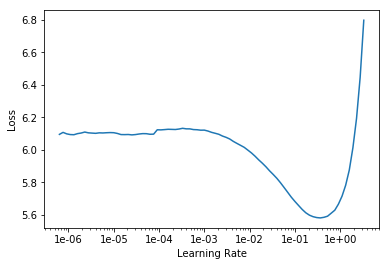

In [64]:
learn.recorder.plot()

In [68]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,4.128924,3.944536,0.354246,1:02:28


In [69]:
learn.save('fit_head')

In [70]:
learn.load('fit_head');

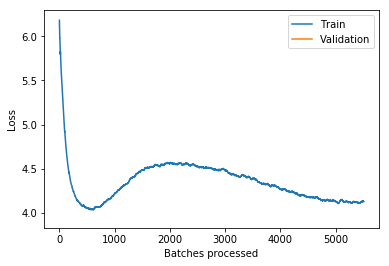

In [71]:
learn.recorder.plot_losses()

In [72]:
learn.unfreeze()

In [73]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,3.754533,3.699181,0.377401,1:09:18
2,3.618573,3.547582,0.391897,1:09:21
3,3.513011,3.456559,0.400357,1:09:18
4,3.456867,3.403648,0.405266,1:09:20
5,3.381757,3.369924,0.408746,1:09:20
6,3.314069,3.347204,0.410793,1:09:22
7,3.261577,3.332373,0.412437,1:09:29
8,3.206742,3.326893,0.413377,1:09:24
9,3.164662,3.326211,0.413647,1:09:23
10,3.143472,3.328176,0.413544,1:09:20


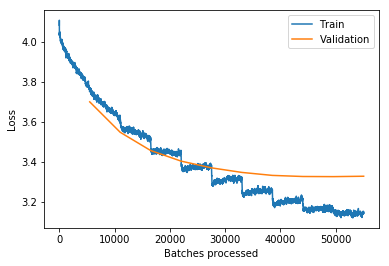

In [74]:
learn.recorder.plot_losses()

In [75]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,3.260679,3.343992,0.411160,1:09:23
2,3.162227,3.320627,0.413942,1:09:22


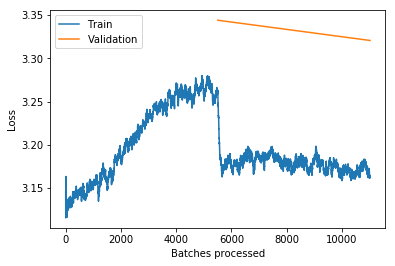

In [76]:
learn.recorder.plot_losses()

In [77]:
learn.save('fine_tuned')

In [78]:
learn.load('fine_tuned');

In [81]:
learn.predict("Why so many", 40, temperature=0.75)

'Why so many Americans think white people should be allowed to vote ? xxbos Why do people use English as a second language if they are not Chinese or Chinese ? xxbos What is the purpose of'

In [83]:
learn.predict("Why machine learning", 40, temperature=0.75)

"Why machine learning is so expensive ? xxbos Will Democrats react to Hillary Clinton 's ' Bill of Rights ' right now ? xxbos What is the negative effect of negative numbers in physics ? xxbos"

In [85]:
learn.predict("Why is the most interesting book", 40, temperature=0.75)

'Why is the most interesting book , the Bible , a good book , and the most true book ? xxbos Which US university is best for a MS in Electrical Engineering ( Masters in Information Science'

In [87]:
learn.save_encoder('fine_tuned_enc')

# Classification

In [156]:
data_clas = TextDataBunch.from_csv(path, 'train.csv', text_cols='question_text', label_cols='target')

In [157]:
data_clas.save('data_clas.pkl')

In [158]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [159]:
data_clas.show_batch()

text,target
xxbos xxmaj what is [ math ] \ frac { \ xxunk } } \ tan ( \ tan ( { \ boxed { \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk } \ sum _ { \ xxunk { \ infty } \ underbrace { \ xxunk } } _ { \ xxunk 's xxmaj law of xxmaj theoretical xxmaj probability .,1
"xxbos xxmaj if xxmaj sonic is going to gather an army of cartoon animals like in xxmaj sonic xxmaj forces , why does n't xxmaj sega enlist xxmaj creative xxmaj assembly -- a studio it owns -- to create a xxmaj sonic xxmaj total xxmaj war game that let 's players control said army against xxmaj dr. xxmaj xxunk 's robot armies ?",0
"xxbos i ’m 26 . i have enough money saved to cover my debit in student loans . i have no issues covering my expenses . xxmaj should i pay off my loans completely , buy my own house , continue my dream to travel , or continue to save until i have it all figured out ?",0
xxbos xxmaj school is not for me . i am a 3.6 xxup gpa student at a top 10 undergrad business school . i feel like i am not learning anything . i am interested in tech and i want to focus on learning web and app development . xxmaj how should i tell my parents ?,0
"xxbos i have recently applied for the course xxup xxunk in xxmaj mount xxmaj carmel xxmaj college , xxmaj bangalore . xxmaj is there anyone who has gone through the personal interview for the same ? xxmaj what are the things i need to be prepared with and what are the questions they ask ?",0


In [160]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [161]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


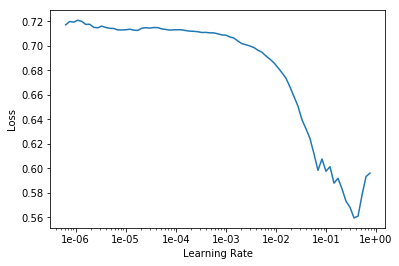

In [162]:
learn.recorder.plot()

In [163]:
learn.fit_one_cycle(5, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.201011,0.178843,0.938712,21:07
2,0.220415,0.197687,0.938566,21:49
3,0.186882,0.176767,0.939317,21:30
4,0.178444,0.172847,0.938750,21:29
5,0.176911,0.166128,0.941311,21:34


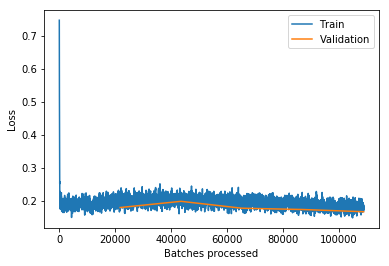

In [164]:
learn.recorder.plot_losses()

In [165]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.182999,0.169764,0.939822,20:50
2,0.198221,0.177881,0.939324,20:42
3,0.188212,0.170516,0.940687,21:08
4,0.184290,0.164622,0.941721,21:52
5,0.177327,0.162136,0.941862,21:07


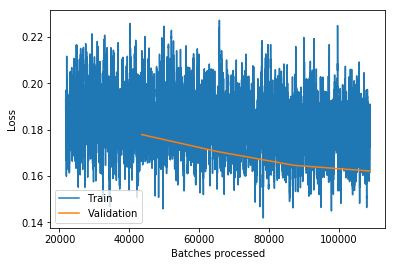

In [168]:
learn.recorder.plot_losses(last=4)

In [169]:
learn.save('first')

In [173]:
learn.load('first');

In [174]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.140434,0.143354,0.948669,25:26


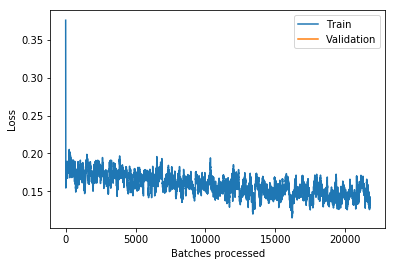

In [175]:
learn.recorder.plot_losses()

In [176]:
learn.save('second')

In [177]:
learn.load('second');

In [178]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.137698,0.147930,0.951268,40:42


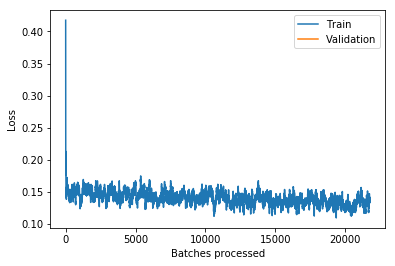

In [179]:
learn.recorder.plot_losses()

In [180]:
learn.save('third')

In [181]:
learn.load('third');

In [182]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.140686,0.133253,0.951835,58:25
2,0.130186,0.126214,0.953155,1:00:10


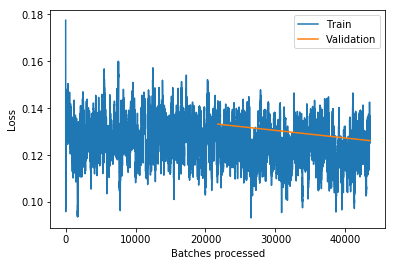

In [183]:
learn.recorder.plot_losses()

In [184]:
learn.save('final')

In [188]:
learn.load('final');

# Evaluation

In [203]:
df = pd.read_csv(path/'train.csv')
df[df.target == 1].head(20)

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1
119,00056d45a1ce63856fc6,Why do females find penises ugly?,1
127,0005de07b07a17046e27,How do I marry an American woman for a Green C...,1
144,00068875d7c82a5bcf88,Why do Europeans say they're the superior race...,1
156,0006ffd99a6599ff35b3,Did Julius Caesar bring a tyrannosaurus rex on...,1
167,00075f7061837807c69f,In what manner has Republican backing of 'stat...,1


In [226]:
df.iloc[208].question_text

'Why are Americans, British, Canadians, Australians and New Zealanders considered to be separate nations even when they all speak the same language?'

In [205]:
learn.predict("Why are Americans, British, Canadians, Australians and New Zealanders considered to be separate nations even when they all speak the same language?")

(<fastai.core.Category at 0x7f094dce0390>, tensor(1), tensor([0.4706, 0.5294]))

In [189]:
learn.predict("What is the most dangerous place in Glasgow?")

(<fastai.core.Category at 0x7f096edd3d30>, tensor(0), tensor([0.9967, 0.0033]))

In [197]:
learn.predict("How do I marry an American woman for a Green Card? How much do they charge?")

(<fastai.core.Category at 0x7f096edd3358>, tensor(0), tensor([0.7358, 0.2642]))

In [198]:
learn.predict("What is the reason why we really need Bitcoin?")

(<fastai.core.Category at 0x7f096edd3208>, tensor(0), tensor([0.9956, 0.0044]))

In [199]:
learn.predict("What is the clipboard feature on a computer?")

(<fastai.core.Category at 0x7f096d8950f0>,
 tensor(0),
 tensor([9.9999e-01, 6.9183e-06]))

In [218]:
learn.predict("Why dogs are so cute?")

(<fastai.core.Category at 0x7f094dca8710>, tensor(0), tensor([0.6806, 0.3194]))

In [225]:
learn.predict("Why people are so dumb?")

(<fastai.core.Category at 0x7f094dca8438>, tensor(1), tensor([0.2736, 0.7264]))

In [227]:
preds = learn.get_preds() # for validation set

In [230]:
preds[1].size(0)

261225

In [232]:
preds[1].sum()

tensor(16190)

In [233]:
preds

[tensor([[0.7969, 0.2031],
         [0.9166, 0.0834],
         [0.9929, 0.0071],
         ...,
         [0.8398, 0.1602],
         [0.5629, 0.4371],
         [0.9731, 0.0269]]), tensor([1, 0, 0,  ..., 1, 1, 1])]

In [234]:
y_true = preds[1]
y_score = preds[0][:,0]

From https://stackoverflow.com/questions/31488517/getting-the-maximum-accuracy-for-a-binary-probabilistic-classifier-in-scikit-lea

In [111]:
import sklearn

precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score)    
auprc  = sklearn.metrics.auc(recall, precision)
max_f1 = 0
for r, p, t in zip(recall, precision, thresholds):
    if p + r == 0: continue
    if (2*p*r)/(p + r) > max_f1:
        max_f1 = (2*p*r)/(p + r) 
        max_f1_threshold = t

ModuleNotFoundError: No module named 'sklearn'

Brute force solution to find optimal F1. A more optimal way is to sort predictions and then gradually increase threshold. Or generate big matrix for predictions with various thresholds to parallelize on GPU

In [235]:
f1_max = 0
for thresh in y_score.unique():
    f1 = fbeta(y_score.view(1, -1), y_true.view(1, -1), sigmoid=False, thresh=thresh)
    if f1 > f1_max:
        f1_max = f1
        f1_thresh = thresh

In [236]:
f1_max, f1_thresh

(tensor(0.2483), tensor(5.8231e-09))